# Coding project - Picture enhancement

Write code that automatically enhances a photograph.

In [1]:
from skimage.io import imread,imshow,imsave
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
def cumul_hist(ima) :
    """Calcule l'histogramme cumulé"""
    h = [(ima ==c).sum() for c in range(256)]
    h = np.array(h)
    norm_hist = h/h.sum()
    histCumul = [0 for v in range (256)]
    for i in range(len(norm_hist)): 
            histCumul[i] = histCumul[i-1]+norm_hist[i]
    return histCumul
    

In [3]:
from skimage.color import rgb2gray
from skimage import img_as_ubyte

def to_8bit (im):
    """Convertit une image en niveau de gris en 8uint"""
    if (len(im.shape)>2):
        ima = rgb2gray(im)
        
    return img_as_ubyte(ima)

In [4]:
def auto_level(im):
    """Renvoie une image qui optimise l'utilisation de l'espace
    disponible pour une image sur 8 bit"""
    ima = to_8bit(im)
    c_h = cumul_hist(ima)
    lut = np.arange(256)
    
    #Definition des valeur min/max de l'image sur base de percentile
    Tmin = 0
    Tmax = 0
    while (c_h[Tmin] < 0.001):
        Tmin+=1
    while (c_h[Tmax] < 0.99):
        Tmax+=1
    
    #Defition du LUT 
    lut[:Tmin]= 0
    lut[Tmax:]=255
    lut[Tmin:Tmax] = (255/(Tmax-Tmin))*(lut[Tmin:Tmax]-Tmin)
    
    return lut[im]

In [17]:
im= imread('etretat.jpg')
new_im = auto_level(im)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(im, cmap=cm.gray)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(new_im, cmap=cm.gray)
plt.title('LUT(Original)')
plt.show()
plt.figure(figsize=(10,2))
plt.subplot(1,2,1) 
plt.hist(im.flatten(), bins=256)
plt.title('Original')
plt.subplot(1,2,2)
plt.hist(new_im.flatten(), bins=256)
plt.title('LUT(Original)')
plt.show()


In [18]:
def rgb_construction(rgb,im):
    """Reconstruit une image à l'aide des canaux 
    rouge, vert et bleu."""
    im[:,:,0] = rgb[0]
    im[:,:,1] = rgb[1]
    im[:,:,2] = rgb[2]
    return im

def splitting_rgb (im):
    """Récupère les canaux rgb d'une image"""
    r = im[:,:,0]
    g = im[:,:,1]
    b = im[:,:,2]
    return r,g,b

In [20]:
from skimage.filters.rank import mean, median
from skimage.morphology import disk

def applied_median(im):
    """Application d'un filtre median à l'aide
    d'un disque de rayon 1"""
    im2 = im.copy()
    r,g,b = splitting_rgb(im2)
    r = median(r, disk(1))
    g = median(g, disk(1))
    b = median(b, disk(1))
    im2 = rgb_construction((r,g,b),im2)
    return im2

Le filtre median permet d'enlever du bruit tout en gardant les bords. Cependant, si un bord est trop petit il sera aussi affecté par le filtre médian et donc on perdra en qualité d'image. C'est pourquoi, il préférable de choisir un 'kernel' le plus petit possible (d'où le choix d'un disque de rayon 1).

In [22]:
im = imread('etretat.jpg')
nr_im2 = applied_median(im)
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.imshow(nr_im2[50:150,50:150])
plt.title('NR_IM')
plt.subplot(1,2,2)
plt.imshow(im[50:150,50:150])
plt.title('Original')
plt.show()

In [44]:
from skimage.color import rgb2hsv,hsv2rgb
from skimage.util import img_as_float64

def cor_saturation (im):
    """Renvoie le canal de saturation corrigé d'une image HSV
    sur base de la saturation déjà présente dans l'image"""
    sat = im[:,:,1] 
    #Definition d'un facteur de multiplication de la saturation
    factor = 1/np.quantile(sat,0.99)
    sat = im[:,:,1]*factor
    mask = (sat >1)
    sat[mask] = 1
    return sat

def add_saturation (im):
    """Renvoie le canal de saturation corrigé d'une image HSV
    sur base de la saturation déjà présente dans l'image"""
    sat = img_as_ubyte(im[:,:,1], force_copy=False)
    #Definition d'un facteur de multiplication de la saturation
    c_h = np.array(cumul_hist(sat))
    if (c_h[128]<0.5):
        gamma = 1.3
    else :
        gamma = 0.7
    lut = np.arange(256)
    lut = ((255)**(1-gamma)*(lut**gamma)).astype('uint8')
    sat = lut[sat]
    return img_as_float64(sat)

In [45]:
im = imread('etretat.jpg')
im_hsv = rgb2hsv(im)
im_hsv_s = im_hsv.copy()
im_hsv_s[:,:,1] = im_hsv_s[:,:,1]*0.5
im_hsv[:,:,1] = cor_saturation(im_hsv)
im_hsv[:,:,1] = add_saturation(im_hsv)   


La correction de saturation permet de récuperer de la saturation sur une image désaturée basée sur ses niveaux maximums de saturation. La correction utilise la correction gamma sur le canal de la saturation d'une image hsv afin d'augmenter le contraste de saturation dans la niveaux de saturations les plus denses.

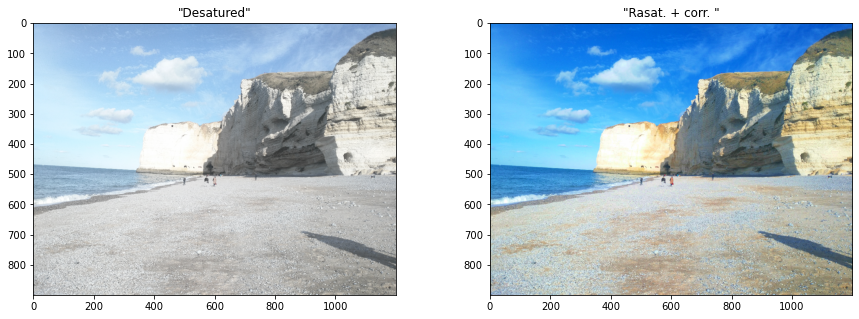

In [47]:
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.hist(im_hsv_s[:,:,1].flatten(),bins=np.arange(101)/100)
plt.title('"Desatured"')
plt.subplot(1,2,2)
plt.hist(im_hsv[:,:,1].flatten(),bins=np.arange(101)/100)
plt.title('"Resatured"')
plt.show()

plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.imshow(hsv2rgb(im_hsv_s))
plt.title('"Desatured"')
plt.subplot(1,2,2)
plt.imshow(hsv2rgb(im_hsv))
plt.title('"Rasat. + corr. "')
plt.show()

In [52]:
def applied_gamma(im,gamma):
    """Crée un lut pour une correction gamma"""
    ima = im.copy()
    lut = np.arange(256)
    lut = ((255)**(1-gamma)*(lut**gamma)).astype('uint8')
    return lut[ima]

In [53]:
def deff_gamma(im):
    """Defini un paramètre gamma pour une correction gamma. Pour définir ce paramètre,
    la fonction cherche à ce que le niveau de gris moyen de la luminance soit plus ou moins
    central sur un histogramme cumulé"""
    ima = im.copy()
    c_h = cumul_hist(im)
    gamma = 1
    while (c_h[128]<0.4 or c_h[128]>0.6):
        ima = im.copy()
        if (c_h[128]<0.40):
            gamma += 0.1
        else : 
            gamma -= 0.1
        ima = applied_gamma(ima,gamma)
        c_h = cumul_hist(ima)
    return gamma

Il s'agit d'une manière de définir gamma. On pourrait aussi imaginer definir des percentiles sur base de l'histogramme cumulé et réaliser en quelque sorte une "equalisation" qui augmenterait de le contraste de l'image.

In [54]:
def gamma_cor(im):
    """Applique une correction gamma à une image"""
    gamma = deff_gamma(im)
    return applied_gamma(im,gamma)

In [58]:
im = imread('etretat.jpg')

cb_im = gamma_cor(applied_gamma(im,0.8))
cd_im = gamma_cor(applied_gamma(im,3))

fig, axs = plt.subplots(2,2,figsize = (10,7))
axs[0, 0].imshow(applied_gamma(im,0.8))
axs[0, 0].set_title('Brighter')
axs[0, 1].imshow(cb_im)
axs[0, 1].set_title('Corrected')
axs[1, 0].imshow(applied_gamma(im,3))
axs[1, 0].set_title('Darker')
axs[1, 1].imshow(cd_im)
axs[1, 1].set_title('Corrected')
for ax in axs.flat:
    ax.label_outer()


Les fonctions, ci-dessous, avaient pour but de créer un 'look vintage' à une image en augmentant les niveaux de noir, et abbaissant les blancs mais finalement elles ne seront pas utilsées.

In [59]:
from math import log
def lut_high_black(yb, yc):
    lut = np.arange(yc)
    coeff_exp = ((log(yc)-log(yb))/yc)
    lut = lut*coeff_exp
    lut = np.exp(lut)*yb
    return lut

def lut_low_white(yc):
    gamma = 0.5
    lut = np.array([i for i in range(yc,256)])
    lut = ((255)**(1-gamma)*(lut**gamma)).astype('uint8')
    lut = (lut-(lut[0]-yc))
    return lut

def vintage_lut(yb,yc):
    lut = np.arange(256)
    lut[:yc] = lut_high_black(yb, yc)
    lut[yc:] = lut_low_white(yc)
    return lut

def vintage_look(im):
    lut = vintage_lut(30,150)
    ima = im.copy()
    return lut[ima]


im = imread('etretat.jpg')
lut = vintage_lut(30,150)
plt.figure(figsize =(15,5))
plt.subplot(1,3,3)
plt.plot(lut)
plt.subplot(1,3,2)
plt.imshow(lut[im])
plt.subplot(1,3,1)
plt.imshow(vintage_look(im))
plt.figure()
    

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

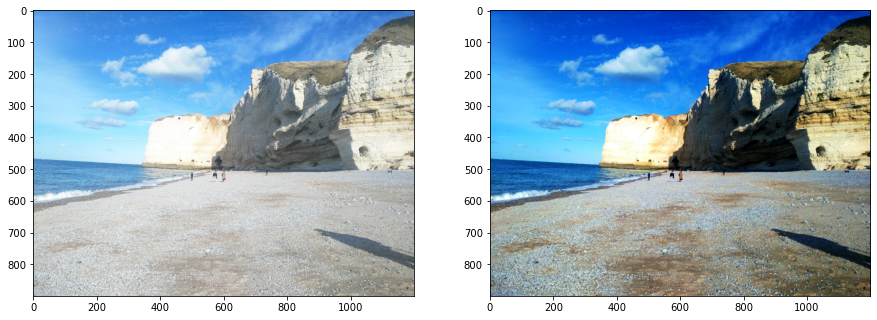

In [62]:
from skimage.color import rgb2hsv,hsv2rgb

def enhance(im) : 
    ima = im.copy()
    
    ima = applied_median(ima)
    
    ima = auto_level(ima)
    
    ima = gamma_cor(ima)
    
    im_hsv = rgb2hsv(ima)
    im_hsv[:,:,1] = cor_saturation(im_hsv)
    im_hsv[:,:,1] = add_saturation(im_hsv)   

    return hsv2rgb(im_hsv)

im = imread('etretat.jpg')
ima = enhance(im)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(ima)
plt.show()

Le résultat obtenur est encore largement perfectible notament les noirs qui sont très sombres et l'image globalement trop contrastée et saturée pour l'oeil.